In [270]:
import numpy as np
np.power(10,5)
np.log10(100000)

5.0

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
words = open('Data\\names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [368]:
import torch
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  



In [196]:
x = torch.randn(5000, 5)
w = (torch.randn(5,10)/ (5**0.5))
a = x@w 
a.std()
torch.tanh(a).std()

tensor(0.5999)

In [369]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
n_embd = 10
block_size = 3
n_hidden=100
vocab_size = 27
C= torch.randn(vocab_size, n_embd, generator=g)
# layers = [Linear(n_embd*block_size, n_hidden ), BatchNorm1d(n_hidden), Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),           Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),           Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),           Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),           Tanh(),
#           Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden)]

layers = [Linear(n_embd*block_size, n_hidden ), Tanh(),
          Linear(n_hidden, n_hidden),           Tanh(),
          Linear(n_hidden, n_hidden),           Tanh(),
          Linear(n_hidden, n_hidden),           Tanh(),
          Linear(n_hidden, n_hidden),           Tanh(),
          Linear(n_hidden, vocab_size)]

parameters= []
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)
parameters = [C] + parameters
print(sum(p.nelement() for p in parameters)) # number of parameters in total

with torch.no_grad():
    layers[-1].weight*=0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight*=5/3

for p in parameters:
    p.requires_grad= True


46497


In [370]:
# max_steps =200000
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    emb = C[Xb]
    emb = emb.view(emb.shape[0], -1)
    x = emb
    for layer in layers:
        x = layer(x)
    
    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
    loss.backward()
    
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data+= -lr * p.grad
    lossi.append(loss.log10().item())
    # print('hey')
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
        # for p in parameters:
        #     ud.append( ((lr*p.grad).std() / p.data.std()).log10().item())
    if i>1000:
        break
    # break



      0/  10000: 3.3124


In [298]:
ud # after 2 runs

[[-3.6652653217315674,
  -3.217061996459961,
  -0.31156763434410095,
  -3.010638475418091,
  -0.2903228998184204,
  -3.1153273582458496,
  -0.30271008610725403,
  -3.171912670135498,
  -0.33077293634414673,
  -3.249877452850342,
  -0.37867411971092224,
  -0.6738789081573486,
  -0.523302435874939],
 [-3.712125778198242,
  -3.21714186668396,
  -0.4913175404071808,
  -2.9930171966552734,
  -0.4372844099998474,
  -3.0777015686035156,
  -0.4766947627067566,
  -3.124746322631836,
  -0.4387839436531067,
  -3.2294650077819824,
  -0.5108519792556763,
  -0.6901671886444092,
  -0.6701411008834839]]

layer 1 (      Tanh): mean -0.08, std 0.77, saturated: 21.62%
layer 3 (      Tanh): mean +0.01, std 0.72, saturated: 12.41%
layer 5 (      Tanh): mean +0.03, std 0.74, saturated: 14.53%
layer 7 (      Tanh): mean -0.01, std 0.73, saturated: 13.94%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 10.84%


Text(0.5, 1.0, 'activation distribution')

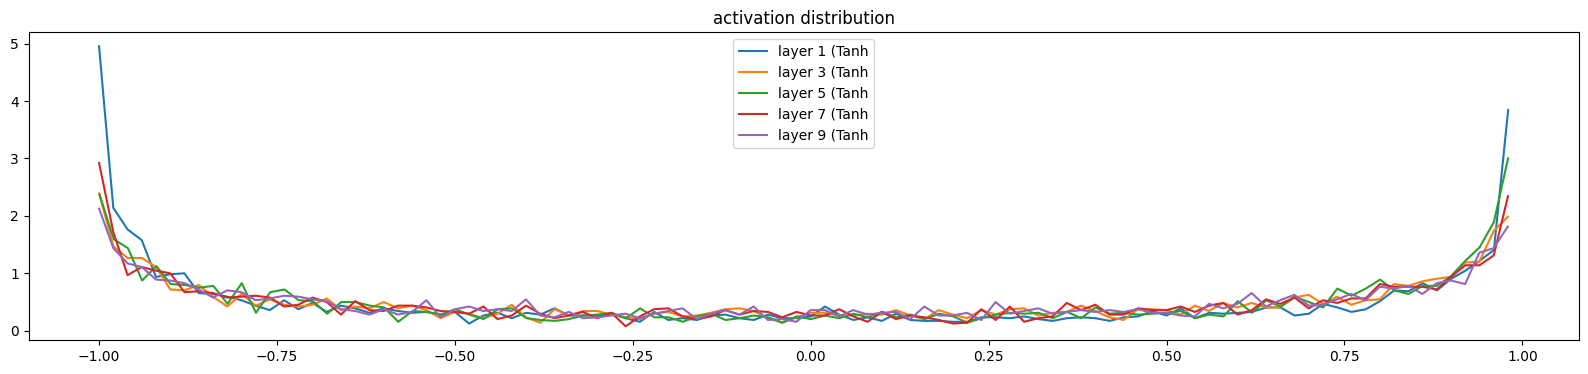

In [371]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.001291, std 9.038927e-02
layer 3 (      Tanh): mean +0.000488, std 3.516888e-02
layer 5 (      Tanh): mean +0.000007, std 1.330358e-02
layer 7 (      Tanh): mean +0.000021, std 4.588986e-03
layer 9 (      Tanh): mean +0.000013, std 1.692718e-03


Text(0.5, 1.0, 'gradient distribution')

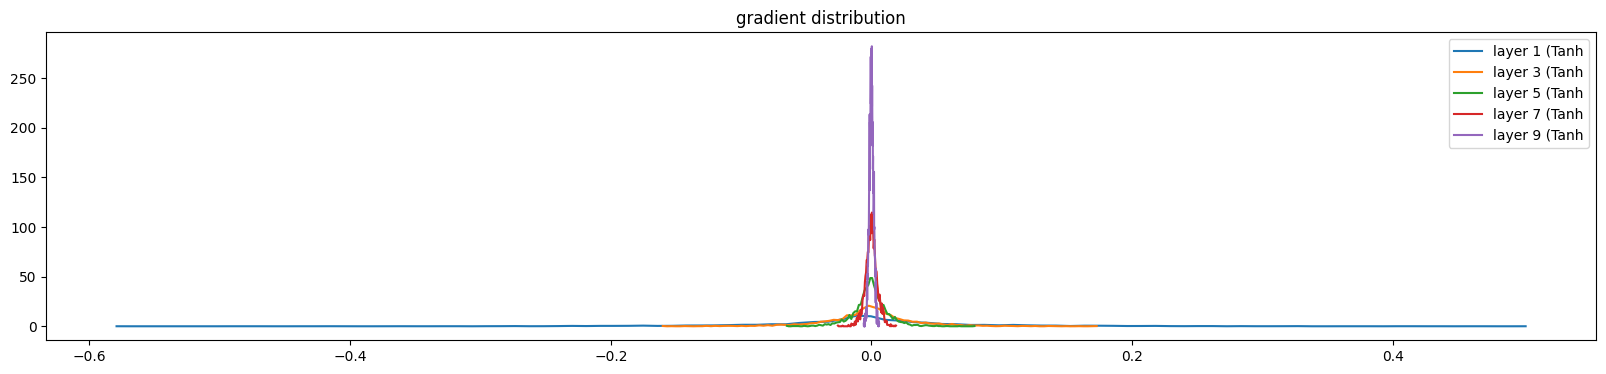

In [364]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

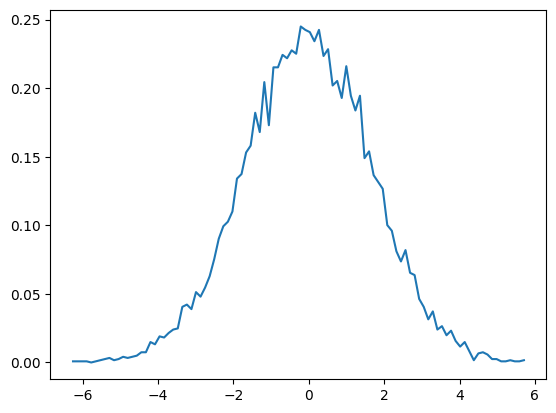

In [365]:
a = layers[6].weight

hy, hx = torch.histogram(a, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

weight   (27, 10) | mean +0.006377 | std 1.886081e-01 | grad:data ratio 7.802272e-02
weight  (30, 100) | mean +0.001761 | std 9.901685e-02 | grad:data ratio 5.186147e-02
weight (100, 100) | mean -0.000256 | std 3.091926e-02 | grad:data ratio 1.851956e-02
weight (100, 100) | mean +0.000017 | std 1.208240e-02 | grad:data ratio 7.192570e-03
weight (100, 100) | mean -0.000024 | std 4.498379e-03 | grad:data ratio 2.690545e-03
weight (100, 100) | mean -0.000005 | std 1.550101e-03 | grad:data ratio 9.263230e-04
weight  (100, 27) | mean -0.000000 | std 2.939112e-02 | grad:data ratio 4.819414e-01


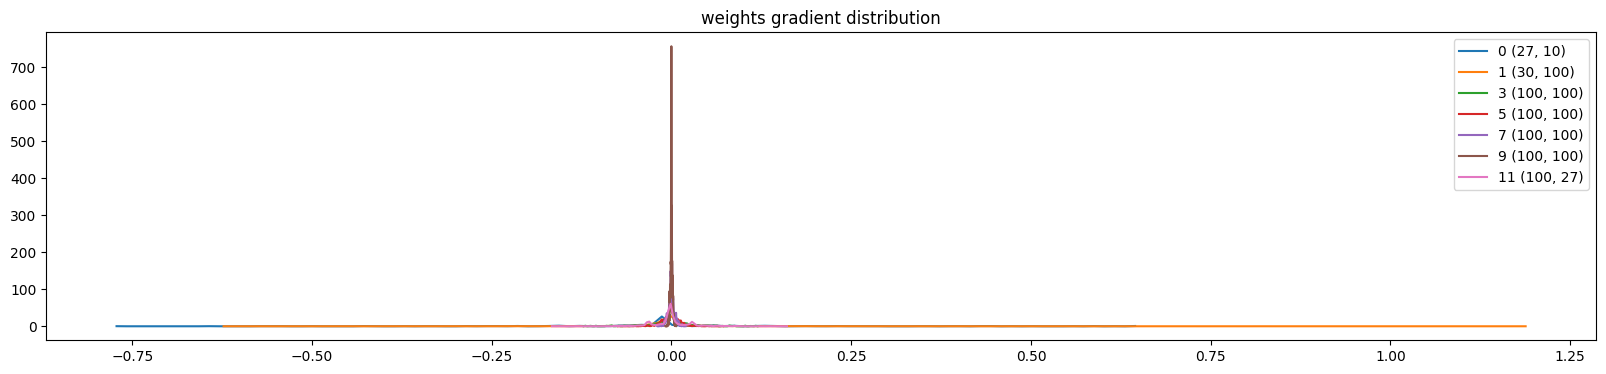

In [366]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [354]:
np.log10(0.03)

-1.5228787452803376

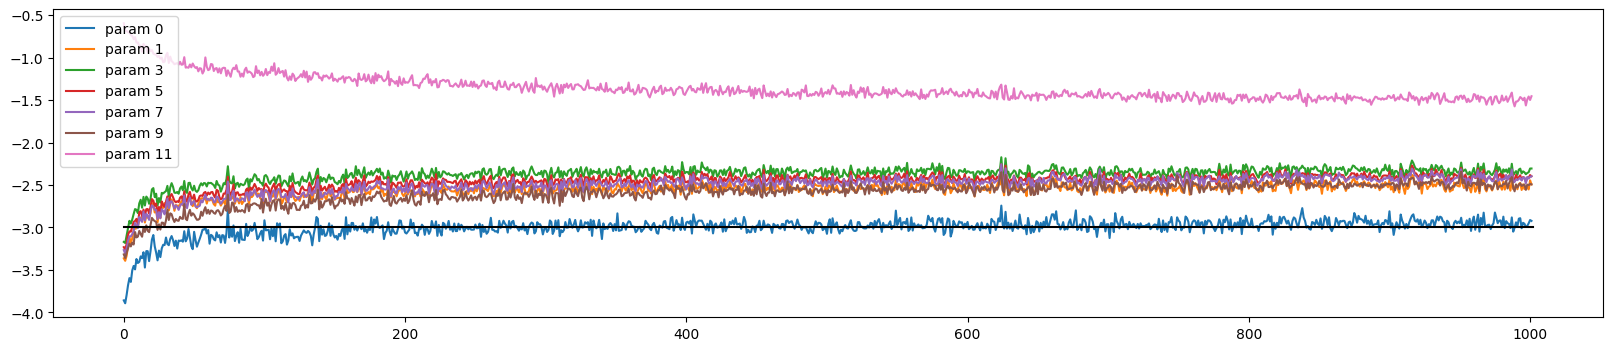

In [373]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: #skip the biases as bias only has ndim =1
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1458635330200195
val 2.209584951400757
